# SageMaker/DeepAR demo on household electricity consumption dataset

This notebook complements the following two notebooks:
* [DeepAR introduction notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb). 
* [Individual household electric power consumption dataset](https://github.com/amirrezaeian/Individual-household-electric-power-consumption-Data-Set-/blob/master/data_e_power.ipynb).

The household electric power consumption dataset is available at:<br>
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In summary, the dataset consists of the following attributes:
* `date`: date (dd/mm/yyyy)
* `time`: time (hh:mm:ss)
* `global_active_power`: household global minute-averaged active power (in Kilowatt) 
* `global_reactive_power`: household global minute-averaged reactive power (in Kilowatt)
* `voltage`: minute-averaged voltage (in Volt)
* `global_intensity`: household global minute-averaged current intensity (in Ampere) 
* `sub_metering_1`: energy sub-metering No.1 (in Watt-per-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
* `sub_metering_2`: energy sub-metering No.2 (in Watt-per-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
* `sub_metering_3`: energy sub-metering No.3 (in Watt-per-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. 

In particular, we will see how to:
* Prepare the dataset
* Use the SageMaker Python SDK to train a DeepAR model and deploy it
* Make requests to the deployed model to obtain forecasts interactively
* Illustrate advanced features of DeepAR: missing values, additional time features, non-regular frequencies and category information

For more information about DeepAR, see the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) 

In [1]:
%matplotlib inline

import sys
import os
import json
import zipfile
import random
import datetime
from urllib.request import urlretrieve
from dateutil.parser import parse
from random import shuffle

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
# from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using MXNet backend.


In [2]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following: 
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [4]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-household-electricity-notebook'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [5]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

Next, we configure the container image to be used for the region that we are running in.

In [6]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

### Importing household electricity consumption dataset

After downloading the original dataset from the UCI ML repository, we load and parse the dataset. In addition, we modify dataset into a time-series formation supported by Pandas, so that we can utilize many features to handle time-series dataset (e.g. datetime, resampling, aggregation, basic statistics, etc.).

* https://www.allaboutcircuits.com/textbook/alternating-current/chpt-11/true-reactive-and-apparent-power/
* https://circuitglobe.com/what-is-power-triangle.html
* https://en.wikipedia.org/wiki/AC_power

<img src="./power-triangle-compressor.jpg" width=400>

### White noise
In discrete time, white noise is a discrete signal whose samples are regarded as a sequence of serially uncorrelated random variables with zero mean and finite variance. Depending on the context, one may also require that the samples be independent and having identical probability distribution (a.k.a. _i.i.d_). In particular, if each sample has a normal distribution with zero mean, the signal is said to be **Gaussian white noise**. 

Some properties of white noise:
* White noise is the simplest example of a **stationary process**. <br>
* if the lag is 0, auto-covariance will be a variance of probability distribution. Otherwise, auto-covariance will be 0. That is:
<br><br>
\begin{equation}
   \gamma_l = 
    \begin{cases}
        Var[e_t] & \text{for $l = 0$} \\
        0 & \text{for $l \neq 0$} 
    \end{cases}
\end{equation}
<br>
* if the lag is 0, auto-correlation will be 1. Otherwise, auto-correlation will be 0. That is:
<br><br>

\begin{equation}
   \rho_l = 
    \begin{cases}
        1 & \text{for $l = 0$} \\
        0 & \text{for $l \neq 0$} 
    \end{cases}
\end{equation}
<br>
* Gaussian white noise can be expressed by:
<br><br>
\begin{equation}
e_t \sim \text{ $i.i.d$ } N(\mu,\sigma^2) \text{ for all $t$}
\end{equation}

**Prewhitening:**
A technique to process a time series data to make it behave statistically like white noise. (The 'pre' means that whitening precedes some other analytical approaches enabling to work better if the additive noise is white).

https://datascienceschool.net/view-notebook/6b963e771dc54f8c8cb23437274a86d6/ <br>
http://hosting.astro.cornell.edu/~cordes/A6523/Prewhitening.pdf

In [7]:
FILE_NAME = './household_power_consumption.csv'

* Note that dataset includes `nan` and `?` as a `string`. They need to be converted to numpy `nan` in importing stage and treated both of them the same.
* Two columns `Date` and `Time` can be merged into one column `Date_Time`.
* The index of dataset need to be reset (with `Date_Time`).

* Data can be downloaded from: http://archive.ics.uci.edu/ml/machine-learning-databases/00235/
* Just open the zip file and grab the file 'household_power_consumption.txt' put it in the directory that you would like to run the code.
* `infer_datetime_format`: to allow speedups for homogeneously formatted datetimes. `pd.read_csv` and `pd.to_datetime` learned a new `infer_datetime_format` keyword which greatly improves parsing perf in many cases. (http://pandas.pydata.org/pandas-docs/version/0.17.1/whatsnew.html#id55)
* `low_memory`: Please refer the following link: https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options)

In [8]:
data = pd.read_csv(FILE_NAME, sep=",", parse_dates={'Date_Time': ['Date', 'Time']}, 
                  infer_datetime_format=True, na_values=['nan','?'], 
                  low_memory=False, index_col='Date_Time')
data.head()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


We need to check the type of data for each column. If some of them has `object` type, they should be converted into the numerical format (e.g. `float64`, `int64`).
For example, we can use the following codes for the above tasks: <br>
```
data = data.convert_objects(convert_numeric=True)
data.info()
```

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


When we want to build an ML model, we need to understand dataset in the following perspectives:
* The meaning of data for each feature (column)
* Summarized information from the basic statistics
* Relaionship or Association between features
* Features having similar patterns
* Trend or Periodicity
* Outliers, Noisy data, Missing values
* Data type (categorical data, numerical data, etc.)
... 

In [10]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


## Dealing with missing values 'nan' with a test statistic

In [11]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,7):
    if not data.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
# droping_list_all

In [12]:
# filling nan with mean in any columns

for j in range(0,7):        
        data.iloc[:,j]=data.iloc[:,j].fillna(data.iloc[:,j].mean())

In [13]:
# another sanity check to make sure that there are not more any nan
data.isnull().sum()
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


We can make a transformed dataset with different frequency by using `resample()`. <br>
**down-sampling:** <br>
* To transform the original dataset to a lower frequencey
* Summarize or aggregate the higher frequency data points (i.e. original dataset)
* Example: 1 minute-based timestamps → 5 minute-based timestamps 

**up-sampling:** <br>
* To transform the original dataset to a higher frequencey
* the lower frequency data points (i.e. original dataset)
* Example: 1 minute-based timestamps → 0.5 minute-based (i.e. 30 second-based) timestamps 

https://machinelearningmastery.com/resample-interpolate-time-series-data-python/ <br>
**Resampling** <br>
Resampling involves changing the frequency of your time series observations.

Two types of resampling are:

1. Upsampling: Where you increase the frequency of the samples, such as from minutes to seconds. For upsampling, `ffill()` (i.e. forward filling) or `bfill()` (i.e. backward filling) can be required to fill the newly created data points that was not available. 
1. Downsampling: Where you decrease the frequency of the samples, such as from days to months. For downsampling, some kind of aggregation operation can be needed. (e.g. `mean()`, `first()`, etc.)

In both cases, data must be invented.

In the case of upsampling, care may be needed in determining how the fine-grained observations are calculated using interpolation. In the case of downsampling, care may be needed in selecting the summary statistics used to calculate the new aggregated values.

There are perhaps two main reasons why you may be interested in resampling your time series data:

1. Problem Framing: Resampling may be required if your data is available at the same frequency that you want to make predictions.
1. Feature Engineering: Resampling can also be used to provide additional structure or insight into the learning problem for supervised learning models.
There is a lot of overlap between these two cases.

For example, you may have daily data and want to predict a monthly problem. You could use the daily data directly or you could downsample it to monthly data and develop your model.

A feature engineering perspective may use observations and summaries of observations from both time scales and more in developing a model.


In [14]:
data['Global_active_power'].resample('M').sum()

Date_Time
2006-12-31    41817.648460
2007-01-31    69014.045230
2007-02-28    56491.069230
2007-03-31    58863.283615
2007-04-30    39245.548781
2007-05-31    44008.872000
2007-06-30    35729.767447
2007-07-31    29846.831570
2007-08-31    34120.475531
2007-09-30    41874.789230
2007-10-31    49278.553230
2007-11-30    55920.827230
2007-12-31    72605.261615
2008-01-31    65170.473615
2008-02-29    49334.346845
2008-03-31    55591.685615
2008-04-30    48209.992000
2008-05-31    45724.043230
2008-06-30    42945.063615
2008-07-31    35479.601230
2008-08-31    12344.063230
2008-09-30    42667.792000
2008-10-31    50743.399447
2008-11-30    59918.584535
2008-12-31    56911.416668
2009-01-31    62951.099615
2009-02-28    50291.953362
2009-03-31    54761.169230
2009-04-30    49277.707230
2009-05-31    45214.196460
2009-06-30    37149.767696
2009-07-31    27594.810460
2009-08-31    30049.032998
2009-09-30    42631.838845
2009-10-31    51089.811615
2009-11-30    55068.733615
2009-12-31    6090

## Data Visualization

Below I resample over day, and show the sum and mean of Global_active_power. It is seen that mean and sum of resampled data set, have similar structure.

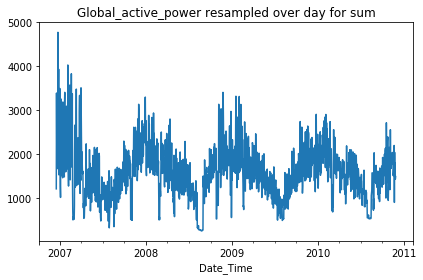

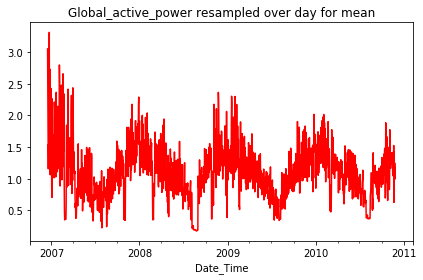

In [15]:
data.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

data.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

Below I show mean and standard deviation (std) of 'Global_intensity' resampled over day.

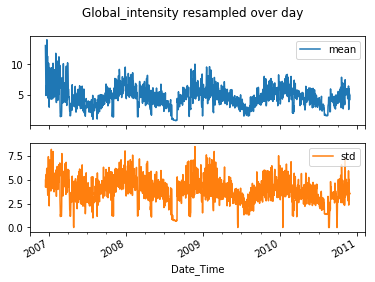

In [16]:
r = data.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

Below I show mean and standard deviation (std) of 'Global_reactive_power' resampled over day.

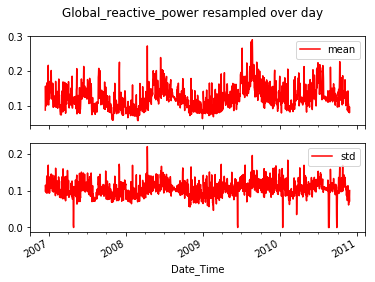

In [17]:
r2 = data.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

Below I show sum of 'global_active_power' resampled over day.

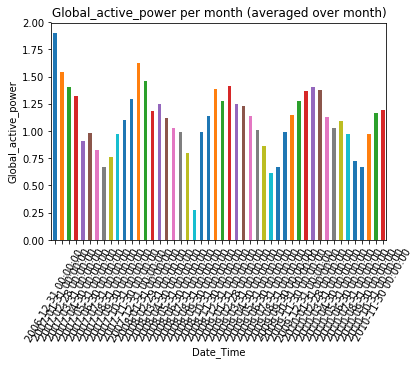

In [18]:
# Sum of 'Global_active_power' resampled over month
data['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

Below I show mean of 'global_active_power' resampled over day.

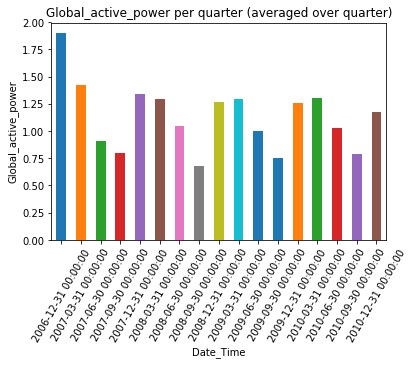

In [19]:
data['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

It is very important to note from above two plots that resampling over larger time inteval, will diminish the periodicity of system as we expect. This is important for machine learning feature engineering.

mean of 'Voltage' resampled over month

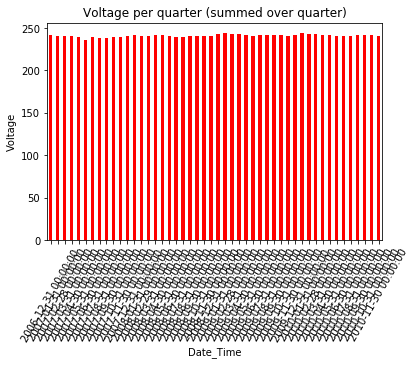

In [20]:
data['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

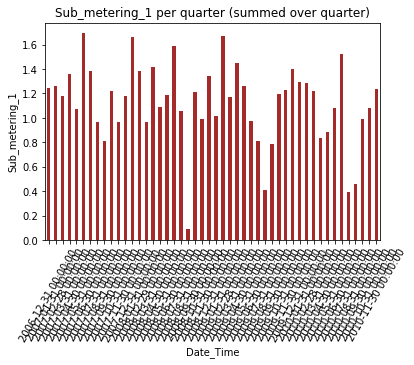

In [21]:
data['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.show()


It is seen from the above plots that the mean of 'Volage' over month is pretty much constant compared to other features. This is important again in feature selection.

### Comparison of the mean of different features resampled over day

In [22]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
values = data.resample('D').mean().values
values

array([[  3.05347475e+00,   8.81868687e-02,   2.36243763e+02, ...,
          0.00000000e+00,   1.37878788e+00,   1.24393939e+01],
       [  2.35448611e+00,   1.56948611e-01,   2.40087028e+02, ...,
          1.41180556e+00,   2.90763889e+00,   9.26458333e+00],
       [  1.53043472e+00,   1.12355556e-01,   2.41231694e+02, ...,
          7.38194444e-01,   1.82013889e+00,   9.73472222e+00],
       ..., 
       [  1.24739444e+00,   9.19861111e-02,   2.40030965e+02, ...,
          7.61111111e-01,   1.97777778e+00,   8.48888889e+00],
       [  9.93863889e-01,   8.06444444e-02,   2.41536257e+02, ...,
          7.47222222e-01,   2.95833333e-01,   3.52222222e+00],
       [  1.17822961e+00,   9.56658749e-02,   2.40291029e+02, ...,
          8.55106888e-01,   3.04829770e-01,   7.90894695e+00]])

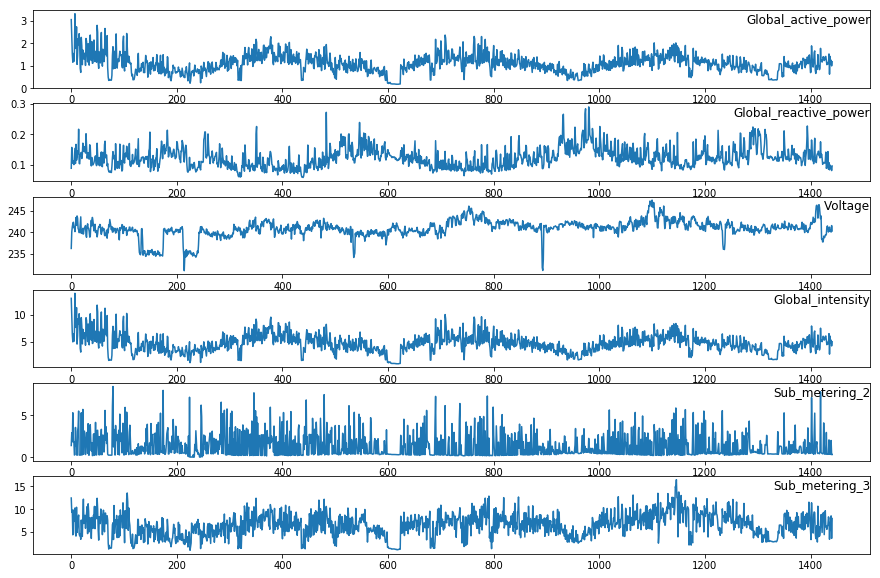

In [23]:
# plot each column
groups = list(data.columns.values)
plt.figure(figsize=(15, 10))
for group in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.75, loc='right')
    i += 1
plt.show()

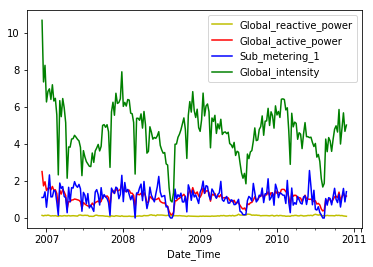

In [24]:
## resampling over week and computing mean
data.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
data.Global_active_power.resample('W').mean().plot(color='r', legend=True)
data.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
data.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

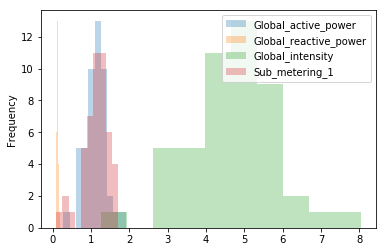

In [25]:
# Below I show hist plot of the mean of different feature resampled over month 
data.Global_active_power.resample('M').mean().plot(kind='hist', alpha=0.3, legend=True )
data.Global_reactive_power.resample('M').mean().plot(kind='hist', alpha=0.3, legend=True)
#df.Voltage.resample('M').sum().plot(kind='hist',color='g', legend=True)
data.Global_intensity.resample('M').mean().plot(kind='hist', alpha=0.3, legend=True)
data.Sub_metering_1.resample('M').mean().plot(kind='hist', alpha=0.3, legend=True)
plt.show()

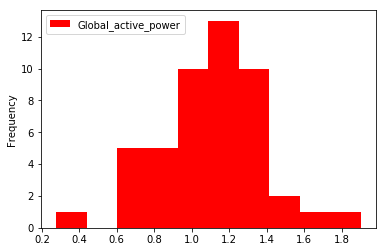

In [26]:
# Below I show hist plot of the mean of different feature resampled over month 
data.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
#from pyqt_fit import kde
plt.show()

### Comparison of the mean of different features resampled over day

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


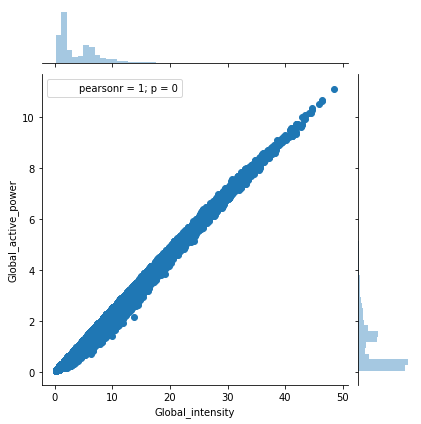

In [27]:
## The correlations between 'Global_intensity', 'Global_active_power'
# data_returns = data.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data)  
plt.show()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


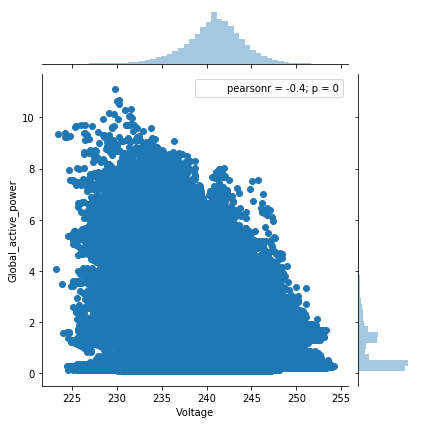

In [28]:
## The correlations between 'Voltage' and  'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data)  
plt.show()

From above two plots it is seen that 'Global_intensity' and 'Global_active_power' correlated. But 'Voltage', 'Global_active_power' are less correlated. This is important observation for machine learning purpose.

### Comparison among features

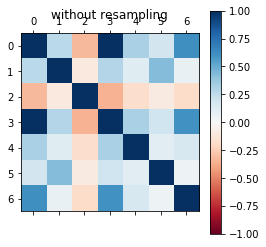

<Figure size 2880x2880 with 0 Axes>

In [29]:
# Correlations among columns
plt.matshow(data.corr(method='spearman'),vmax=1,vmin=-1,cmap='RdBu')
plt.title('without resampling')
plt.colorbar()
plt.figure(figsize=(40,40))
plt.show()

### Comparison of mean of resampled features

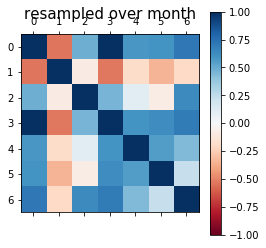

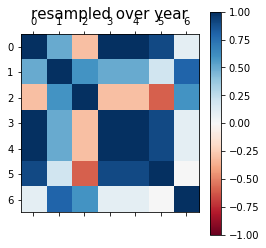

In [30]:
# Correlations of mean of features resampled over months
plt.matshow(data.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='RdBu')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(data.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='RdBu')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

It is seen from above that with resampling techniques one can change the correlations among features. This is important for feature engineering.

In [31]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


Please check your scatter_matrix as below: <br>
<img src="./ScreenShot-2018-07-18-15-18-02.png" width="800"/>

#### StatsModels

`statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. The package is released under the open source Modified BSD (3-clause) license. The online documentation is hosted at [statsmodels.org](http://www.statsmodels.org/).

1. Statistics `stats`
    * statistical tests
    * kernel density estimation
    * generalized method of moments 
<br><br>
1. Linear regression
    * Linear model
    * Generalized Linear Model (GLM)
    * Robust Linear Model
    * Linear Mixed Effects Model
    * ANOVA (Analysis of Variance)
    * Discrete Dependent Variable 
<br><br>
1. Time-Series analysis
    * ARMA/ARIMA process
    * Vector ARMA process

In [75]:
timeseries = data.Global_active_power.resample('D').mean()
# for i in range(num_timeseries):
#     timeseries.append(np.trim_zeros(data.iloc[:,i], trim='f'))

In [76]:
timeseries.head()

Date_Time
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
Freq: D, Name: Global_active_power, dtype: float64

In [77]:
len(timeseries)

1442

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [199]:
# we use minute frequency for the time series
freq = 'D'

# we predict for 60 days 
prediction_length = 60

# we also use 60 days as context length, 
# this is the number of state updates accomplished before making predictions
context_length = 60

We specify here the portion of the data that is used for training: the model sees data from 2006-12-16 to 2008-12-31 for training.

In [201]:
timeseries.head()

Date_Time
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
Freq: D, Name: Global_active_power, dtype: float64

In [202]:
start_dataset = pd.Timestamp("2006-12-16", freq=freq)
end_training = pd.Timestamp("2010-07-11", freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [203]:
training_data = [
    {
        "start": str(start_dataset),
        "target": timeseries[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
        # "target": ts[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    #for ts in timeseries
]
# print(len(training_data))

In [204]:
len(timeseries[start_dataset:end_training -1])

1303

In [205]:
test_data = [
    {
        "start": str(start_dataset),
        "target": timeseries[end_training:end_training + 10 * prediction_length].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    #for ts in timeseries
]
# print(len(test_data))

In [206]:
len(timeseries[end_training:end_training + 10 * prediction_length])

139

Let's now write the dictionary to the `jsonlines` file format that DeepAR understands (it also supports gzipped jsonlines and parquet).

In [207]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [208]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.18 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes.

In [209]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [210]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-west-2-742595989409/deepar-household-electricity-notebook/data/train/train.json
Uploading file to s3://sagemaker-us-west-2-742595989409/deepar-household-electricity-notebook/data/test/test.json
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 122 ms


Let's have a look to what we just wrote to S3.

In [211]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2006-12-16 00:00:00", "target": [3.0534747474747492, 2.354486111111111, 1.530434722222219...


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [212]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    base_job_name='deepar-home-electricity-demo',
    output_path=s3_output_path
)

Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [213]:
# hyperparameters = {
#     "time_freq": freq,
#     "epochs": "5",
#     "early_stopping_patience": "10",
#     "mini_batch_size": "20",
#     "learning_rate": "0.001",
#     "context_length": str(context_length),
#     "prediction_length": str(prediction_length)
# }
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [214]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [215]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: deepar-home-electricity-demo-2018-07-27-03-15-18-550


......................
Arguments: train
[07/27/2018 03:18:46 INFO 140074042410816] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/27/2018 03:18:46 INFO 140074042410816] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'40', u'prediction_length': u'60', u'epochs': u'20', u'time_freq': u'D', u'context_length': u'60', u'num_layers': u'3', u'mini_batch_size': u

[07/27/2018 03:18:56 INFO 140074042410816] processed a total of 302 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1514.8308277130127, "sum": 1514.8308277130127, "min": 1514.8308277130127}}, "EndTime": 1532661536.943273, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532661535.428385}

[07/27/2018 03:18:56 INFO 140074042410816] #throughput_metric: host=algo-1, train throughput=199.347825875 records/second
[07/27/2018 03:18:56 INFO 140074042410816] #progress_metric: host=algo-1, completed 30 % of epochs
[07/27/2018 03:18:56 INFO 140074042410816] best epoch loss so far
[07/27/2018 03:18:56 INFO 140074042410816] Saved checkpoint to "/opt/ml/model/state_3f6d3df6-d554-4ddc-8d21-74d95b98ed84-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 45.50004005432129, "sum": 45.50004005432129, "min": 45.50004005432129}}, "EndTime": 1532661536.989284, "Dimensions": {"Host": "algo-1", "Operation": "trai

[07/27/2018 03:19:06 INFO 140074042410816] Epoch[12] Batch[0] avg_epoch_loss=0.125290
[07/27/2018 03:19:07 INFO 140074042410816] Epoch[12] Batch[5] avg_epoch_loss=0.090269
[07/27/2018 03:19:07 INFO 140074042410816] Epoch[12] Batch [5]#011Speed: 225.58 samples/sec#011loss=0.090269
[07/27/2018 03:19:08 INFO 140074042410816] Epoch[12] Batch[10] avg_epoch_loss=0.041725
[07/27/2018 03:19:08 INFO 140074042410816] Epoch[12] Batch [10]#011Speed: 222.48 samples/sec#011loss=-0.016528
[07/27/2018 03:19:08 INFO 140074042410816] processed a total of 326 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1660.499095916748, "sum": 1660.499095916748, "min": 1660.499095916748}}, "EndTime": 1532661548.378843, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532661546.717875}

[07/27/2018 03:19:08 INFO 140074042410816] #throughput_metric: host=algo-1, train throughput=196.311152772 records/second
[07/27/2018 03:19:08 INFO 140074042410816] 

#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 3564.686059951782, "sum": 3564.686059951782, "min": 3564.686059951782}}, "EndTime": 1532661569.080128, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1532661565.515531}

[07/27/2018 03:19:29 INFO 140074042410816] #test_score (algo-1, RMSE): 0.38677016793
[07/27/2018 03:19:29 INFO 140074042410816] #test_score (algo-1, mean_wQuantileLoss): 0.203314
[07/27/2018 03:19:29 INFO 140074042410816] #test_score (algo-1, wQuantileLoss[0.1]): 0.119702
[07/27/2018 03:19:29 INFO 140074042410816] #test_score (algo-1, wQuantileLoss[0.2]): 0.186436
[07/27/2018 03:19:29 INFO 140074042410816] #test_score (algo-1, wQuantileLoss[0.3]): 0.232395
[07/27/2018 03:19:29 INFO 140074042410816] #test_score (algo-1, wQuantileLoss[0.4]): 0.260534
[07/27/2018 03:19:29 INFO 140074042410816] #test_score (algo-1, wQuantileLoss[0.5]): 0.270927
[07/27/2018 03:19:29 INFO 140074042410816] #test_score (algo-1, wQu

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sagemaker/session.py:782: DeprecationWarning: generator 'multi_stream_iter' raised StopIteration
  for idx, event in sagemaker.logs.multi_stream_iter(client, log_group, stream_names, positions):


===== Job Complete =====
Billable seconds: 168
CPU times: user 468 ms, sys: 48 ms, total: 516 ms
Wall time: 4min 42s


Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [99]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [216]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

INFO:sagemaker:Creating model with name: forecasting-deepar-2018-07-27-03-22-49-329
INFO:sagemaker:Creating endpoint with name deepar-home-electricity-demo-2018-07-27-03-15-18-550


--------------------------------------------------------------!

### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

In [217]:
predictor.predict(timeseries[:-prediction_length], quantiles=[0.10, 0.5, 0.90])

,0.1,0.5,0.9
2010-09-28,0.790016,0.968579,1.102380
2010-09-29,0.744394,0.925553,1.131745
2010-09-30,0.780791,0.999924,1.199642
2010-10-01,0.853651,1.013829,1.180801
2010-10-02,0.792879,0.994975,1.229360
2010-10-03,0.775380,0.958632,1.198079
2010-10-04,0.762203,0.960841,1.154595
2010-10-05,0.770622,1.005522,1.173487
2010-10-06,0.773807,0.982053,1.176765
2010-10-07,0.899876,1.072179,1.279244


Below we define a plotting function that queries the model and displays the forecast.

In [218]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80
):
    print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section.plot(color="black", label='target')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

We can interact with the function previously defined, to look at the forecast of any customer at any point in (future) time. 

For each request, the predictions are obtained by calling our served model on the fly.

Here we forecast the consumption of an office after week-end (note the lower week-end consumption). 
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from our served endpoint and see the plot.

In [219]:
style = {'description_width': 'initial'}

In [241]:
list_of_df = predictor.predict(timeseries[:-prediction_length])
actual_data = timeseries[-prediction_length:]

In [242]:
len(actual_data)

60

In [243]:
list_of_df

,0.1,0.5,0.9
2010-09-28,0.790016,0.968579,1.102380
2010-09-29,0.744394,0.925553,1.131745
2010-09-30,0.780791,0.999924,1.199642
2010-10-01,0.853651,1.013829,1.180801
2010-10-02,0.792879,0.994975,1.229360
2010-10-03,0.775380,0.958632,1.198079
2010-10-04,0.762203,0.960841,1.154595
2010-10-05,0.770622,1.005522,1.173487
2010-10-06,0.773807,0.982053,1.176765
2010-10-07,0.899876,1.072179,1.279244


In [244]:
timeseries.tail()

Date_Time
2010-11-22    1.417733
2010-11-23    1.095511
2010-11-24    1.247394
2010-11-25    0.993864
2010-11-26    1.178230
Freq: D, Name: Global_active_power, dtype: float64

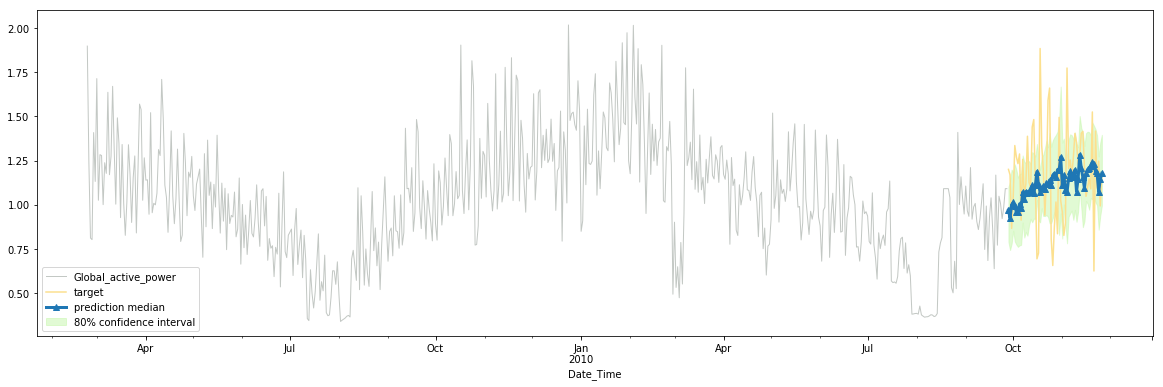

In [264]:
plt.figure(figsize=(20,6))
timeseries[800:-len(list_of_df)].plot(color='#C3C8C4', linewidth=1.0)
p10 = list_of_df['0.1']
p90 = list_of_df['0.9']
plt.fill_between(p10.index, p10, p90, color='#C5F7AB', alpha=0.5, label='80% confidence interval')
actual_data.plot(color='#FCE08F', label='target')
list_of_df['0.5'].plot(marker='^', linewidth=3.0, label='prediction median')
plt.legend()
plt.show()

# Additional features

DeepAR has additional features such as handling the missing values as below:

* missing values: DeepAR can handle missing values in the time series during training as well as for inference.
* Additional time features: DeepAR provides a set default time series features such as hour of day etc. However, you can provide additional feature time series via the `dynamic_feat` field. 
* generalize frequencies: any integer multiple of the previously supported base frequencies (minutes `min`, hours `H`, days `D`, weeks `W`, month `M`) are now allowed; e.g., `15min`. We already demonstrated this above by using `2H` frequency.
* categories: If your time series belong to different groups (e.g. types of product, regions, etc), this information can be encoded as one or more categorical features using the `cat` field.


Based on the previous results, we will be able to impelement the advanced models to support the above features.

### Delete endpoints

In [ ]:
predictor.delete_endpoint()